In [1]:
import numpy as np
import pandas as pd
import subprocess
from Bio import pairwise2
import tqdm
import random

random.seed(42)
tlp = "/Users/john/data/deaminase/{}"
df = pd.read_json(tlp.format("index_af.json"),lines=True)
sdf = pd.read_json(tlp.format("index.json"),lines=True)[["accession","name","interpro"]]
sdf.rename(columns={"accession":"uniprotAccession","name":"pfam"},inplace=True)
df = pd.merge(df,sdf,on="uniprotAccession")
limit =20
sequences=[ s for s in df["uniprotSequence"].values][:limit]
accessions=[ s for s in df["uniprotAccession"].values][:limit]
mpfam=dict([(v[1].uniprotId,v[1].pfam) for v in df[:limit].iterrows()])
# 初始化相似度矩阵
n = len(sequences)
gnames=[v for v in df["uniprotId"].values][:limit]


def simseq(i, j):
    s1, s2 =sequences[i],sequences[j]
    alignments = pairwise2.align.globalxx(s1, s2)
    alignment = alignments[0]
    score = alignment[2]
    similarity = score / max(len(s1), len(s2))
    return similarity


def simpdb(i, j):
    pdb1 = tlp.format(f"pdbs/{accessions[i]}.pdb")
    pdb2 = tlp.format(f"pdbs/{accessions[j]}.pdb")
    cmd = ['TMalign', pdb1, pdb2]
    result = subprocess.run(cmd, capture_output=True, text=True)
    output = result.stdout
    for line in output.split('\n'):
        if 'TM-score=' in line and 'if normalized by length of Chain_2' in line:
            return line.strip().split()[1]
    return 0

def color_mapping(pfam):
    # 将病毒属映射到不同的颜色
    # 这里使用一个简单的随机颜色方案，你也可以使用其他更复杂的方案
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))
    


similarity_matrix = np.zeros((n, n))

# 计算两两之间的相似度
for i in tqdm.tqdm(range(n)):
    for j in range(i, n):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            similarity=simseq(i,j)
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

# 创建pfam与颜色的映射关系
pfam_colors = {pfam: color_mapping(pfam) for pfam in set(mpfam.values()) if pfam}
unipro_colors={k:pfam_colors[mpfam[k]] for k in mpfam }

# 打印相似度矩阵
correlations = pd.DataFrame(data={gnames[i]:similarity_matrix[:][i] for i, g in enumerate(gnames)})
correlations.index=gnames
correlations

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.45it/s]


,CDD_BACSU,CDD_HUMAN,CDD_MYCGE,CDD_MYCPI,CDD_MOUSE,CDD_MYCPN,CDD_YEAST,CDD_SCHPO,CDD_DICDI,CDD_BACHD,CDD_SPOPS,CDD_AERHH,CDD_ECOK1,CDD_YERPP,CDD_ENT38,CDD_VIBC3,CDD_HAEIE,CDD_HAEIG,CDD_KLEP7,CDD_YERP3
CDD_BACSU,1.000000,0.520548,0.411765,0.477941,0.506849,0.426471,0.492958,0.492647,0.503401,0.654412,0.661765,0.255973,0.255102,0.238095,0.251701,0.267797,0.250000,0.253425,0.251701,0.238095
CDD_HUMAN,0.520548,1.000000,0.397260,0.452055,0.815068,0.424658,0.472603,0.520548,0.544218,0.479452,0.520548,0.249147,0.251701,0.248299,0.258503,0.254237,0.267123,0.263699,0.248299,0.248299
CDD_MYCGE,0.411765,0.397260,1.000000,0.496241,0.376712,0.676692,0.443662,0.451128,0.394558,0.416667,0.448529,0.225256,0.234694,0.224490,0.231293,0.237288,0.256849,0.253425,0.214286,0.224490
CDD_MYCPI,0.477941,0.452055,0.496241,1.000000,0.445205,0.496241,0.478873,0.496241,0.448980,0.488722,0.492647,0.228669,0.244898,0.231293,0.238095,0.230508,0.250000,0.250000,0.227891,0.231293
CDD_MOUSE,0.506849,0.815068,0.376712,0.445205,1.000000,0.404110,0.465753,0.486301,0.537415,0.486301,0.513699,0.255973,0.255102,0.251701,0.261905,0.271186,0.246575,0.246575,0.255102,0.251701
CDD_MYCPN,0.426471,0.424658,0.676692,0.496241,0.404110,1.000000,0.415493,0.458647,0.414966,0.443609,0.470588,0.238908,0.231293,0.214286,0.224490,0.227119,0.239726,0.239726,0.231293,0.214286
CDD_YEAST,0.492958,0.472603,0.443662,0.478873,0.465753,0.415493,1.000000,0.514085,0.448980,0.436620,0.457746,0.259386,0.238095,0.234694,0.231293,0.247458,0.253425,0.253425,0.238095,0.234694
CDD_SCHPO,0.492647,0.520548,0.451128,0.496241,0.486301,0.458647,0.514085,1.000000,0.469388,0.488722,0.500000,0.232082,0.238095,0.224490,0.231293,0.237288,0.229452,0.229452,0.231293,0.224490
CDD_DICDI,0.503401,0.544218,0.394558,0.448980,0.537415,0.414966,0.448980,0.469388,1.000000,0.482993,0.510204,0.245734,0.265306,0.255102,0.255102,0.257627,0.256849,0.256849,0.258503,0.255102
CDD_BACHD,0.654412,0.479452,0.416667,0.488722,0.486301,0.443609,0.436620,0.488722,0.482993,1.000000,0.625000,0.249147,0.255102,0.238095,0.248299,0.257627,0.239726,0.246575,0.248299,0.238095


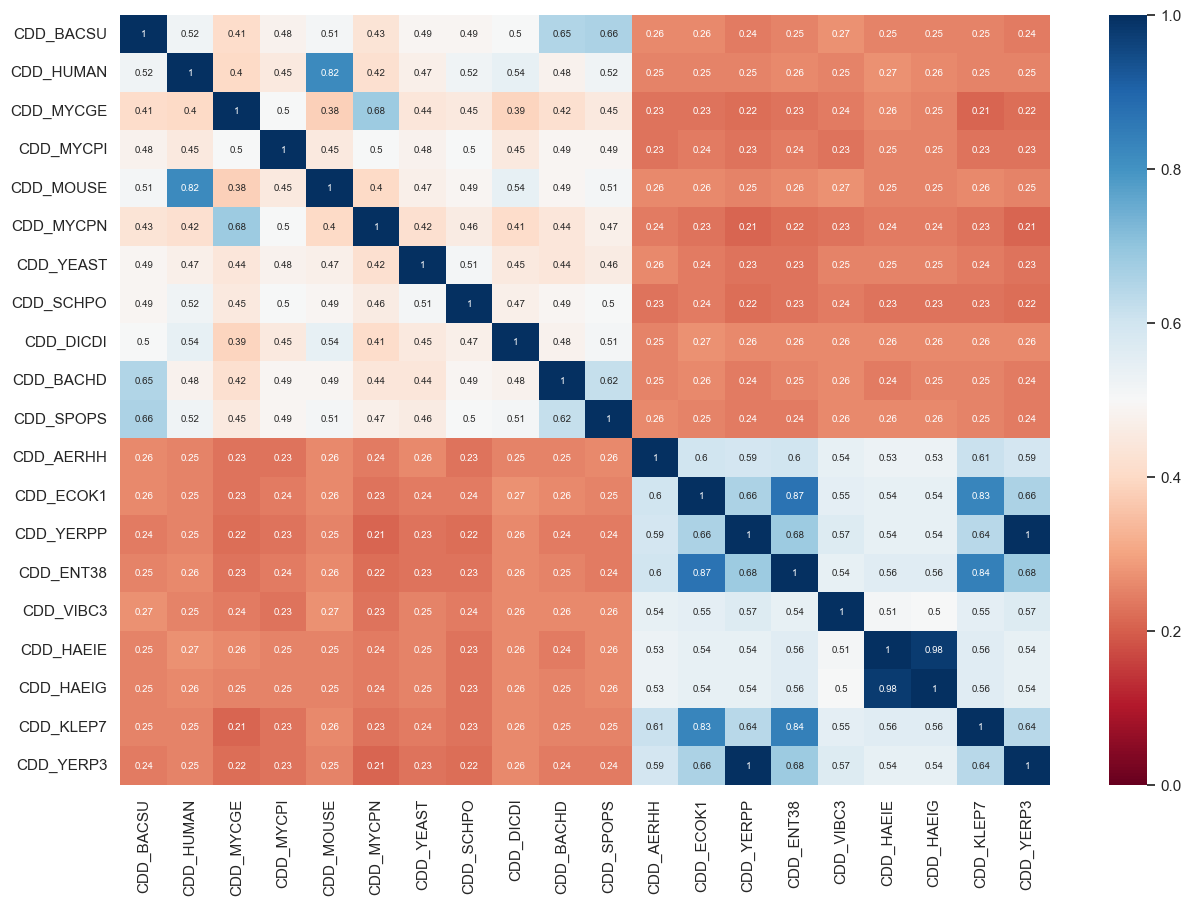

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15,10))
ax = sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0, vmax=1)

# sns.set(style='white')
# fig, ax = plt.subplots(figsize=(12, 9))
# # fig, ax = plt.subplots()
# sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
#             annot_kws={"size": 5}, vmin=0, vmax=1, cbar=True)
for xtick in ax.get_xticklabels():
    xtick.horizontalalignment="left"
#     color = unipro_colors[xtick._text]
#     xtick.set_backgroundcolor(color)
for ytick in ax.get_yticklabels():
    ytick.horizontalalignment="left"
# ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
# plt.yticks(rotation=0, ha='left')  # 确保标签左对齐
# plt.subplots_adjust(left=0.3)
# plt.yticks(rotation=0, ha='left')

plt.show()

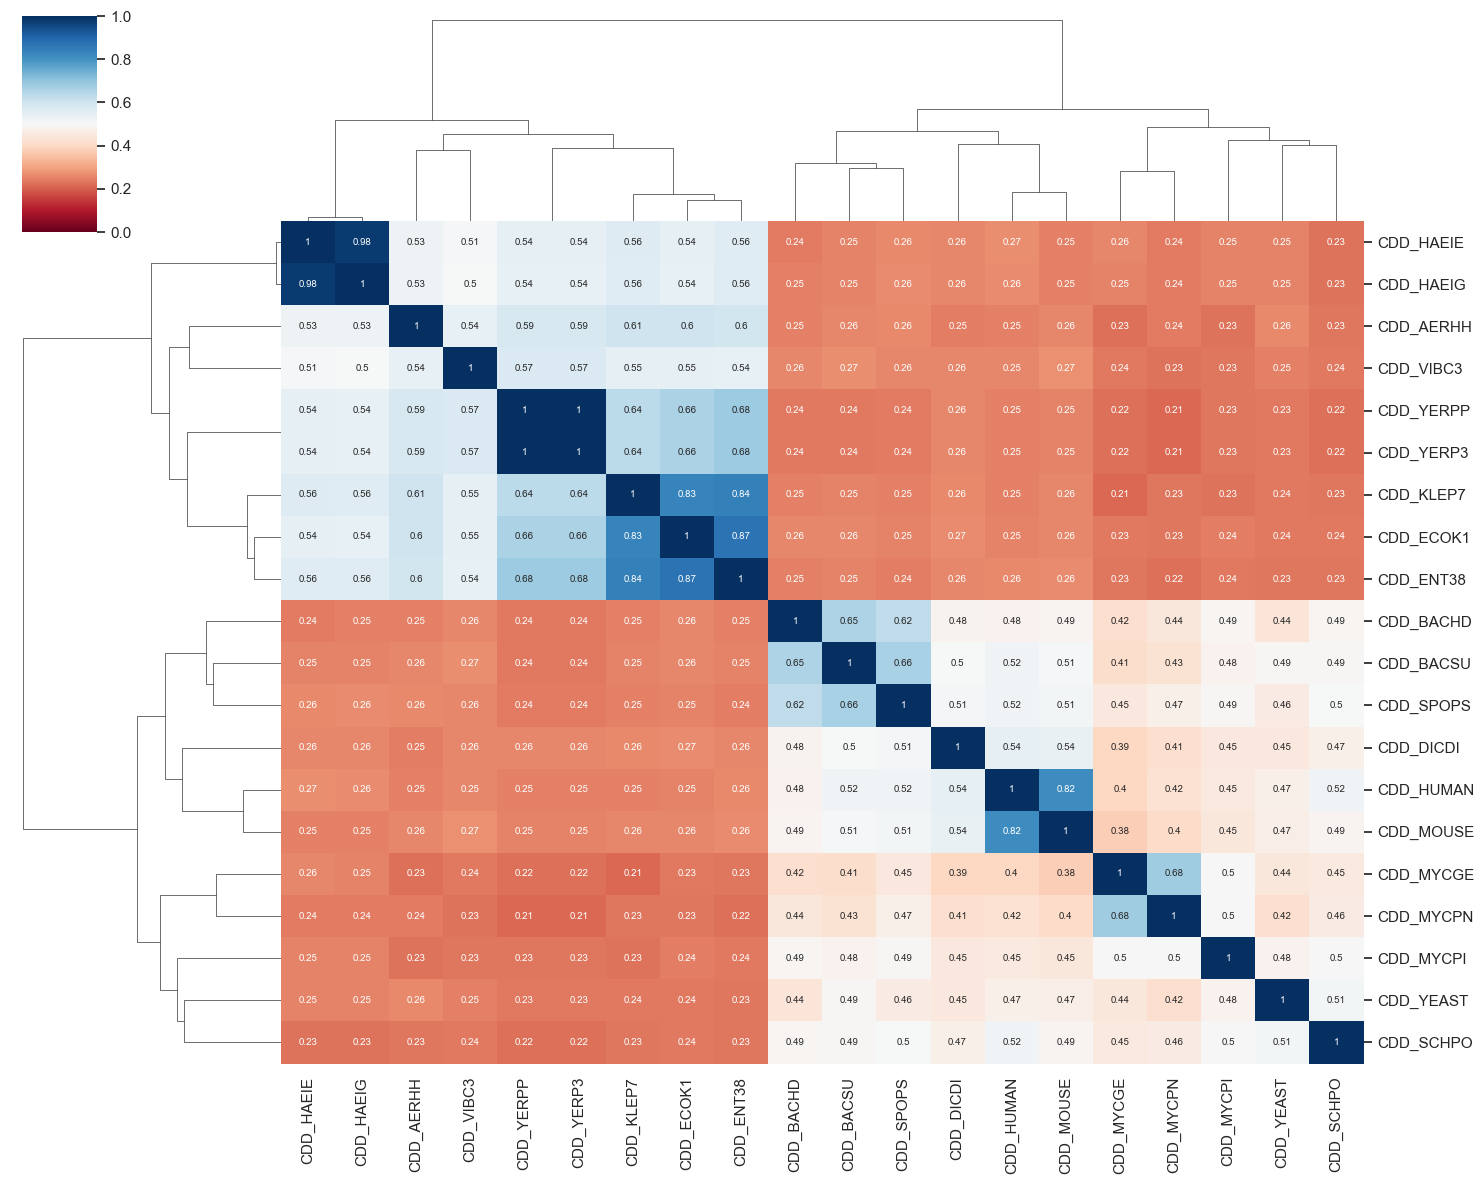

In [51]:
sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=0, vmax=1, figsize=(15,12));

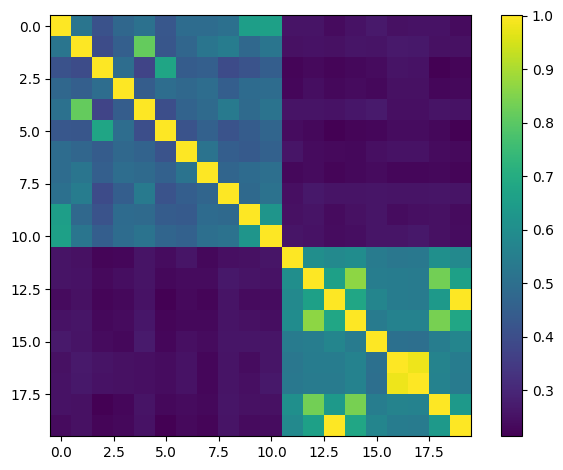

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(similarity_matrix)
plt.colorbar()
plt.tight_layout()
plt.show()

/var/folders/g3/9kgyg0z54nv7fpxy0pgwx0y80000gn/T/ipykernel_1703/391594293.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')  # 'ward'方法最小化各簇内的方差


Newick格式字符串: (((((CDD_VIBC3,CDD_AERHH) ,(CDD_YERP3,CDD_YERPP) ) ,((CDD_ENT38,CDD_ECOK1) ,CDD_KLEP7) ) ,(CDD_HAEIG,CDD_HAEIE) ) ,((((CDD_MOUSE,CDD_HUMAN) ,CDD_DICDI) ,((CDD_SPOPS,CDD_BACSU) ,CDD_BACHD) ) ,(((CDD_SCHPO,CDD_YEAST) ,CDD_MYCPI) ,(CDD_MYCPN,CDD_MYCGE) ) ) );


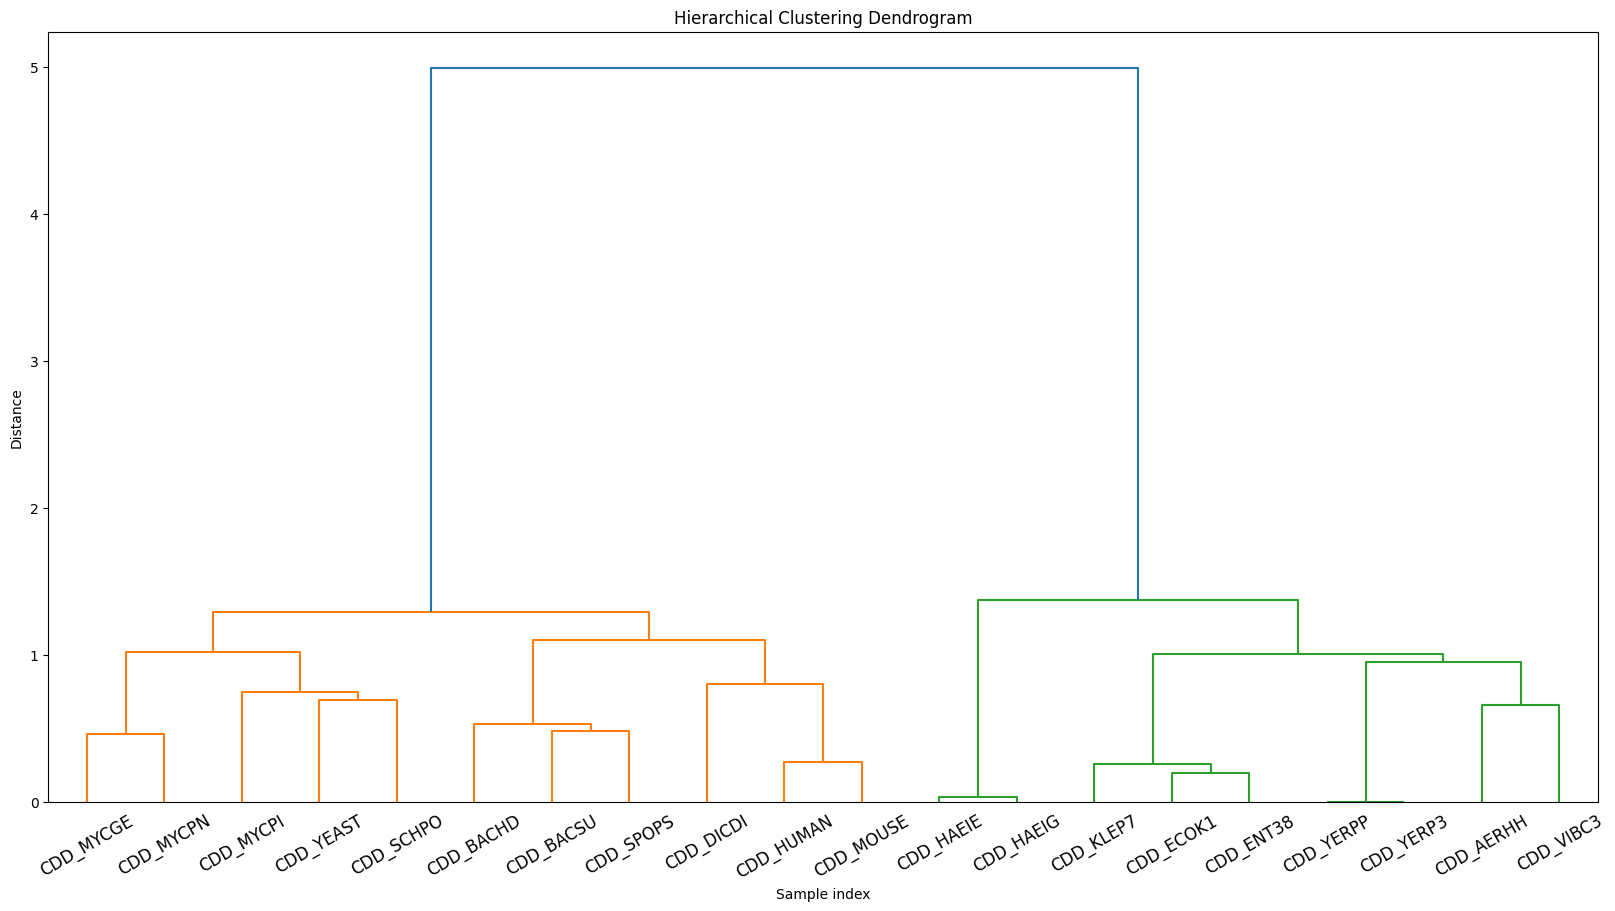

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, linkage, to_tree
from scipy.spatial.distance import pdist

# 创建示例数据
distance_matrix = 1 - similarity_matrix
# 使用linkage函数进行层次聚类
Z = linkage(distance_matrix, method='ward')  # 'ward'方法最小化各簇内的方差

# 转换为树结构
root_node, nodes = to_tree(Z, rd=True)


def get_newick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
#         return f"{leaf_names[node.id]}:{parentdist - node.dist}{newick}"
        return f"{leaf_names[node.id]}{newick}"
    else:
        if len(newick) > 0:
#             newick = f"): {parentdist - node.dist}{newick}"
            newick = f") {newick}"
        else:
            newick = ");"
        newick = get_newick(node.get_left(), newick, node.dist, leaf_names)
        newick = get_newick(node.get_right(), f",{newick}", node.dist, leaf_names)
        newick = f"({newick}"
        return newick

# 生成叶节点名称（假设数据点的索引为叶节点名称）
leaf_names = gnames
# 生成Newick格式字符串
newick_str = get_newick(root_node, "", root_node.dist, leaf_names)
print("Newick格式字符串:",newick_str)

# # 将Newick格式字符串保存到文件
# with open("tree.nwk", "w") as file:
#     file.write(newick_str)

# 绘制树状图
plt.figure(figsize=(20, 10))
dendrogram(Z, labels=gnames)
plt.title('Hierarchical Clustering Dendrogram')
plt.xticks(rotation=30)
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [6]:




def get_node_number(node):
    s = set()
    for child in node.traverse():
        if child.is_leaf():
            name = mpfam.get(child.name)
            s.add(name)
    return s




from ete3 import Tree, TreeStyle, NodeStyle, TextFace,AttrFace, faces, RectFace
tree = Tree(newick_str)
ts = TreeStyle()
ts.show_leaf_name = False  # 显示叶子节点名称
ts.mode = "c"  # 环状模式
ts.legend_position = 1


for node in tree.traverse():
    if node.is_leaf():
        # 设置叶子节点样式
        color = unipro_colors.get(node.name,"white")
        nstyle = NodeStyle()
        nstyle["size"] = 0
        nstyle["fgcolor"] = color
        nstyle["hz_line_color"] = color  # 设置水平枝干颜色
        nstyle["vt_line_color"] = color  # 设置垂直枝干颜色
        node.set_style(nstyle)
        host = node.name[:5]
        node.name = host
        face = AttrFace("name", fsize=100)
        host_face = TextFace(f"{host}", ftype="Arial", fsize=100, fgcolor="black",penwidth=1)
        bg_face = faces.RectFace(width=400, height=100, fgcolor="black", bgcolor=color,label=host)
        host_face.background.color =color
        face.background.color =color
        node.add_face(face, column=1, position="aligned")

    else:
        # 设置内部节点样式
        nstyle = NodeStyle()
        pfams = get_node_number(node)
        pfam=pfams.pop()
        color = "black" if len(pfams) else pfam_colors.get(pfam,"black")
        nstyle["hz_line_color"] = color  # 设置水平枝干颜色
        nstyle["vt_line_color"] = color  # 设置垂直枝干颜色
        nstyle["fgcolor"] = "green"
        nstyle["size"] = 0
        node.set_style(nstyle)

# 添加图例
def add_legend(tree_style):
    colors = [ e  for e in pfam_colors.items()]
    for i,(pfam,color) in enumerate(colors):
        column = int(i/10)
        row = i-10*column
        face = TextFace(f"{pfam}: ", ftype="Arial", fsize=100, fgcolor="black")
        color_face = RectFace(400, 100, fgcolor=color,bgcolor=color)
        # 使用一个虚拟节点将图例放置在树的顶部或底部
        tree_style.legend.add_face(face, column=column*2)
        tree_style.legend.add_face(color_face, column=column*2+1)

# 自定义节点样式
# for node in tree.traverse():
#     if node.is_leaf():
#         # 设置叶子节点样式
#         nstyle = NodeStyle()
#         nstyle["size"] = 0
#         node.set_style(nstyle)
        
#     else:
#         # 设置内部节点样式
#         nstyle = NodeStyle()
#         nstyle["fgcolor"] = "black"
#         nstyle["size"] = 0
#         node.set_style(nstyle)

add_legend(ts)
# 绘制并显示树
tree.show(tree_style=ts)

In [3]:
import numpy as np
import pandas as pd
import subprocess
from Bio import pairwise2
import tqdm
import random

random.seed(42)
tlp = "/Users/john/data/protelomerase/{}"
df = pd.read_excel(tlp.format("20240608.xlsx"))
limit =60
sequences=[ s for s in df["Sequence"].values][:limit]
accessions=[ s for s in df["Entry"].values][:limit]
# mpfam=dict([(v[1].uniprotId,v[1].pfam) for v in df[:limit].iterrows()])
# 初始化相似度矩阵
n = len(sequences)
gnames=[v for v in df["Entry"].values][:limit]


def simseq(i, j):
    s1, s2 =sequences[i],sequences[j]
    alignments = pairwise2.align.globalxx(s1, s2)
    alignment = alignments[0]
    score = alignment[2]
    similarity = score / max(len(s1), len(s2))
    return similarity


def simpdb(i, j):
    pdb1 = tlp.format(f"pdbs/{accessions[i]}.pdb")
    pdb2 = tlp.format(f"pdbs/{accessions[j]}.pdb")
    cmd = ['TMalign', pdb1, pdb2]
    result = subprocess.run(cmd, capture_output=True, text=True)
    output = result.stdout
    for line in output.split('\n'):
        if 'TM-score=' in line and 'if normalized by length of Chain_2' in line:
            return line.strip().split()[1]
    return 0

def color_mapping(pfam):
    # 将病毒属映射到不同的颜色
    # 这里使用一个简单的随机颜色方案，你也可以使用其他更复杂的方案
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))
    


similarity_matrix = np.zeros((n, n))

# 计算两两之间的相似度
for i in tqdm.tqdm(range(n)):
    for j in range(i, n):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            similarity=simseq(i,j)
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

# 创建pfam与颜色的映射关系
# pfam_colors = {pfam: color_mapping(pfam) for pfam in set(mpfam.values()) if pfam}
# unipro_colors={k:pfam_colors[mpfam[k]] for k in mpfam }

# 打印相似度矩阵
correlations = pd.DataFrame(data={gnames[i]:similarity_matrix[:][i] for i, g in enumerate(gnames)})
correlations.index=gnames
correlations

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]


,A0A1I9KF59,A0A135P1F3,A0A650BUH5,A0A1S7TII3,A0A1S7QGM1,A0A1S7M2J9,A0A2W5FGK1,Q7CWV1,A0A9W5B0R9,A0A4D7DUQ3,...,A0A2I6TD05,B5LWE9,B0ZSI2,A2I304,A0AAE7KWT7,A0A1Q8YTV9,Q6UAV6,A0A2Z2EKN0,A0A202KS30,A0A378H444
A0A1I9KF59,1.000000,0.310016,0.305246,0.308426,0.308426,0.306836,0.306836,0.303657,0.306836,0.306836,...,0.100159,0.273450,0.359300,0.368839,0.384375,0.390625,0.387500,0.387500,0.390625,0.131955
A0A135P1F3,0.310016,1.000000,0.697309,0.695067,0.695067,0.695067,0.690583,0.701794,0.695067,0.845291,...,0.130045,0.334081,0.359615,0.353160,0.309375,0.312500,0.312500,0.309375,0.312500,0.165919
A0A650BUH5,0.305246,0.697309,1.000000,0.986425,0.990950,0.914027,0.961538,0.920814,0.945824,0.701124,...,0.128959,0.339367,0.355769,0.351301,0.309375,0.304688,0.307812,0.304688,0.304688,0.169683
A0A1S7TII3,0.308426,0.695067,0.986425,1.000000,0.981900,0.911765,0.966063,0.918552,0.945824,0.696629,...,0.128959,0.334842,0.353846,0.349442,0.309375,0.304688,0.307812,0.306250,0.303125,0.169683
A0A1S7QGM1,0.308426,0.695067,0.990950,0.981900,1.000000,0.911765,0.959276,0.918552,0.945824,0.701124,...,0.128959,0.334842,0.355769,0.353160,0.309375,0.303125,0.307812,0.301563,0.303125,0.167421
A0A1S7M2J9,0.306836,0.695067,0.914027,0.911765,0.911765,1.000000,0.914027,0.923077,0.909707,0.701124,...,0.126984,0.340136,0.353846,0.347584,0.310937,0.303125,0.307812,0.306250,0.304688,0.170068
A0A2W5FGK1,0.306836,0.690583,0.961538,0.966063,0.959276,0.914027,1.000000,0.927602,0.945824,0.701124,...,0.126697,0.328054,0.351923,0.347584,0.310937,0.306250,0.309375,0.309375,0.306250,0.169683
Q7CWV1,0.303657,0.701794,0.920814,0.918552,0.918552,0.923077,0.927602,1.000000,0.911964,0.710112,...,0.126697,0.334842,0.355769,0.343866,0.304688,0.300000,0.303125,0.303125,0.301563,0.169683
A0A9W5B0R9,0.306836,0.695067,0.945824,0.945824,0.945824,0.909707,0.945824,0.911964,1.000000,0.707865,...,0.128668,0.327314,0.359615,0.355019,0.312500,0.304688,0.310937,0.306250,0.306250,0.171558
A0A4D7DUQ3,0.306836,0.845291,0.701124,0.696629,0.701124,0.701124,0.701124,0.710112,0.707865,1.000000,...,0.121348,0.339326,0.363462,0.351301,0.304688,0.306250,0.301563,0.304688,0.306250,0.164045


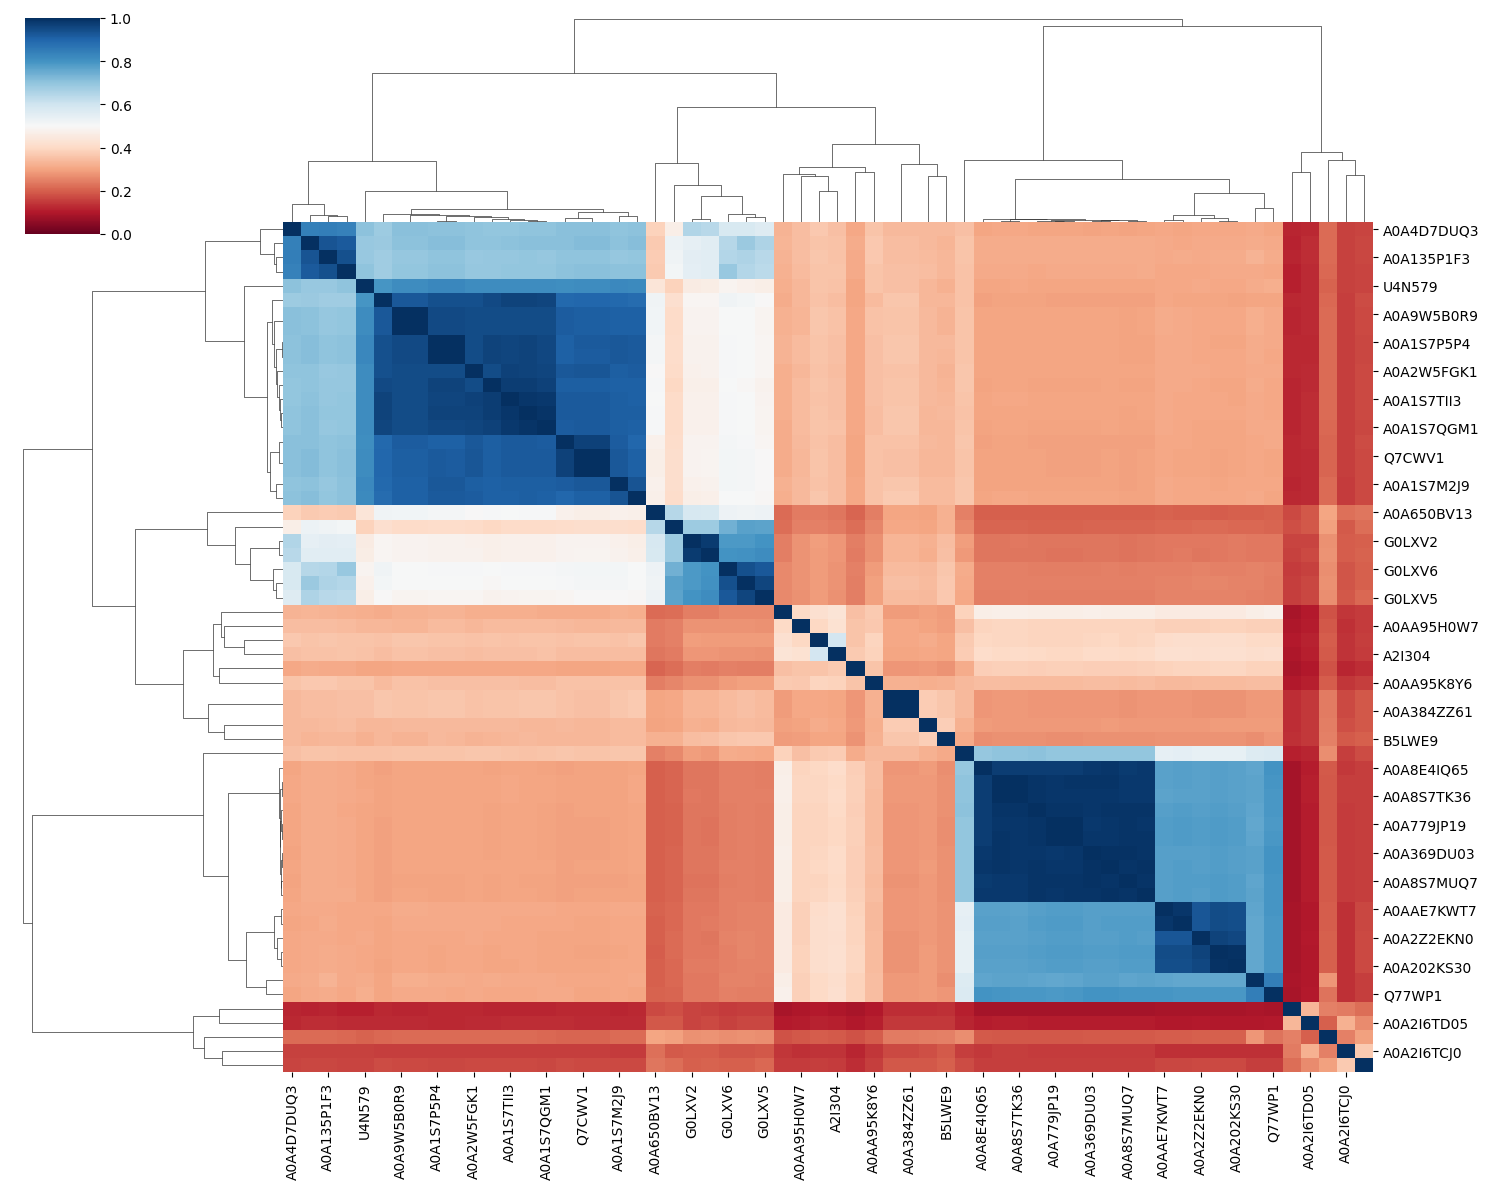

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.clustermap(correlations, method="complete", cmap='RdBu', annot=False, 
               annot_kws={"size": 7}, vmin=0, vmax=1, figsize=(15,12));